# Tracking Information Flow

We have explored how one could generate better inputs that can penetrate deeper into the program in question. While doing so, we have relied on program crashes to tell us that we have succeeded in finding problems in the program. However, that is rather simplistic. What if the behavior of the program is simply incorrect, but does not lead to a crash? Can one do better?

In this chapter, we explore in depth how to track information flows in Python, and how these flows can be used to determine whether a program behaved as expected.

**Prerequisites**

* You should have read the [chapter on coverage](Coverage.ipynb).
* You should have read the [chapter on probabilistic fuzzing](ProbabilisticGrammarFuzzer.ipynb).

We first set up our infrastructure so that we can make use of previously defined functions.

In [1]:
import bookutils

In [2]:
from typing import List, Any, Optional, Union

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.InformationFlow import <identifier>
```

and then make use of the following features.


This chapter provides two wrappers to Python _strings_ that allow one to track various properties. These include information on the security properties of the input, and information on originating indexes of the input string.

### Tracking String Taints

`tstr` objects are replacements for Python strings that allows to track and check _taints_ – that is, information on from where a string originated. For instance, one can mark strings that originate from third party input with a taint of "LOW", meaning that they have a low security level. The taint is passed in the constructor of a `tstr` object:

```python
>>> thello = tstr('hello', taint='LOW')
```
A `tstr` object is fully compatible with original Python strings. For instance, we can index it and access substrings:

```python
>>> thello[:4]
'hell'
```
However, the `tstr` object also stores the taint, which can be accessed using the `taint` attribute:

```python
>>> thello.taint
'LOW'
```
The neat thing about taints is that they propagate to all strings derived from the original tainted string.
Indeed, any operation from a  `tstr` string that results in a string fragment produces another `tstr` object that includes the original taint. For example:

```python
>>> thello[1:2].taint  # type: ignore
'LOW'
>>> from ClassDiagram import display_class_hierarchy
>>> display_class_hierarchy(tstr)
```
![](PICS/InformationFlow-synopsis-1.svg)

### Tracking Character Origins

`ostr` objects extend `tstr` objects by not only tracking a taint, but also the originating _indexes_ from the input string, This allows you to exactly track where individual characters came from. Assume you have a long string, which at index 100 contains the password `"joshua1234"`. Then you can save this origin information using an `ostr` as follows:

```python
>>> secret = ostr("joshua1234", origin=100, taint='SECRET')
```
The `origin` attribute of an `ostr` provides access to a list of indexes:

```python
>>> secret.origin
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
>>> secret.taint
'SECRET'
```
`ostr` objects are compatible with Python strings, except that string operations return `ostr` objects (together with the saved origin an index information). An index of `-1` indicates that the corresponding character has no origin as supplied to the `ostr()` constructor:

```python
>>> secret_substr = (secret[0:4] + "-" + secret[6:])
>>> secret_substr.taint
'SECRET'
>>> secret_substr.origin
[100, 101, 102, 103, -1, 106, 107, 108, 109]
>>> from ClassDiagram import display_class_hierarchy
>>> display_class_hierarchy(ostr)
```
![](PICS/InformationFlow-synopsis-2.svg)



## A Vulnerable Database

Say we want to implement an *in-memory database* service in Python. Here is a rather flimsy attempt. We use the following dataset.

In [3]:
INVENTORY = """\
1997,van,Ford,E350
2000,car,Mercury,Cougar
1999,car,Chevy,Venture\
"""

In [4]:
VEHICLES = INVENTORY.split('\n')

Our DB is a Python class that parses its arguments and throws `SQLException` which is defined below.

In [5]:
class SQLException(Exception):
    pass

The database is simply a Python `dict` that is exposed only through SQL queries.

In [6]:
class DB:
    def __init__(self, db={}):
        self.db = dict(db)

### Representing Tables

The database contains tables, which are created by a method call `create_table()`. Each table data structure is a pair of values. The first one is the meta data containing column names and types. The second value is a list of values in the table.

In [7]:
class DB(DB):
    def create_table(self, table, defs):
        self.db[table] = (defs, [])

The table can be retrieved using the name using the `table()` method call.

In [8]:
class DB(DB):
    def table(self, t_name):
        if t_name in self.db:
            return self.db[t_name]
        raise SQLException('Table (%s) was not found' % repr(t_name))

Here is an example of how to use both.  We fill a table `inventory` with four columns: `year`, `kind`, `company`, and `model`.  Initially, our table is empty.

In [9]:
def sample_db():
    db = DB()
    inventory_def = {'year': int, 'kind': str, 'company': str, 'model': str}
    db.create_table('inventory', inventory_def)
    return db

Using `table()`, we can retrieve the table definition as well as its contents.

In [10]:
db = sample_db()
db.table('inventory')

({'year': int, 'kind': str, 'company': str, 'model': str}, [])

We also define `column()` for retrieving the column definition from a table declaration.

In [11]:
class DB(DB):
    def column(self, table_decl, c_name):
        if c_name in table_decl: 
            return table_decl[c_name]
        raise SQLException('Column (%s) was not found' % repr(c_name))

In [12]:
db = sample_db()
decl, rows = db.table('inventory')
db.column(decl, 'year')

int

### Executing SQL Statements

The `sql()` method of `DB` executes SQL statements.  It inspects its arguments, and dispatches the query based on the kind of SQL statement to be executed.

In [13]:
class DB(DB):
    def do_select(self, query):
        ...

    def do_update(self, query):
        ...

    def do_insert(self, query):
        ...

    def do_delete(self, query):
        ...

    def sql(self, query):
        methods = [('select ', self.do_select),
                   ('update ', self.do_update),
                   ('insert into ', self.do_insert),
                   ('delete from', self.do_delete)]
        for key, method in methods:
            if query.startswith(key):
                return method(query[len(key):])
        raise SQLException('Unknown SQL (%s)' % query)

Here's an example of how to use the `DB` class:

In [14]:
some_db = DB()
some_db.sql('select year from inventory')

However, at this point, the individual methods for handling SQL statements are not yet defined. Let us do this in the next steps.

### Excursion: Implementing SQL Statements

#### Selecting Data

The `do_select()` method handles SQL `select` statements to retrieve data from a table.

In [15]:
class DB(DB):
    def do_select(self, query):
        FROM, WHERE = ' from ', ' where '
        table_start = query.find(FROM)
        if table_start < 0:
            raise SQLException('no table specified')

        where_start = query.find(WHERE)
        select = query[:table_start]

        if where_start >= 0:
            t_name = query[table_start + len(FROM):where_start]
            where = query[where_start + len(WHERE):]
        else:
            t_name = query[table_start + len(FROM):]
            where = ''
        _, table = self.table(t_name)

        if where:
            selected = self.expression_clause(table, "(%s)" % where)
            selected_rows = [hm for i, data, hm in selected if data]
        else:
            selected_rows = table

        rows = self.expression_clause(selected_rows, "(%s)" % select)
        return [data for i, data, hm in rows]

The `expression_clause()` method is used for two purposes:

1. In the form `select` $x$, $y$, $z$ `from` $t$, it _evaluates_ (and returns) the expressions $x$, $y$, $z$ in the contexts of the selected rows.
2. If a clause `where` $p$ is given, it also evaluates $p$ in the context of the rows and includes the rows in the selection only if $p$ holds.

To evaluate expressions like $x$, $y$, $z$ or $p$, we make use of the Python `eval()` evaluation function.

In [16]:
class DB(DB):
    def expression_clause(self, table, statement):
        selected = []
        for i, hm in enumerate(table):
            selected.append((i, self.my_eval(statement, {}, hm), hm))

        return selected

Which internally calls `my_eval()` to evaluate any given statement.

In [17]:
class DB(DB):
    def my_eval(self, statement, g, l):
        try:
            return eval(statement, g, l)
        except:
            raise SQLException('Invalid WHERE (%s)' % repr(statement))

**Note:** Using `eval()` here introduces some important security issues, which we will discuss later in this chapter.

Here's how we can use `sql()` to issue a query.  Note that the table is yet empty.

In [18]:
db = sample_db()
db.sql('select year from inventory')

[]

In [19]:
db = sample_db()
db.sql('select year from inventory where year == 2018')

[]

#### Inserting Data

The `do_insert()` method handles SQL `insert` statements.

In [20]:
class DB(DB):
    def do_insert(self, query):
        VALUES = ' values '
        table_end = query.find('(')
        t_name = query[:table_end].strip()
        names_end = query.find(')')
        decls, table = self.table(t_name)
        names = [i.strip() for i in query[table_end + 1:names_end].split(',')]

        # verify columns exist
        for k in names:
            self.column(decls, k)

        values_start = query.find(VALUES)

        if values_start < 0:
            raise SQLException('Invalid INSERT (%s)' % repr(query))

        values = [
            i.strip() for i in query[values_start + len(VALUES) + 1:-1].split(',')
        ]

        if len(names) != len(values):
            raise SQLException(
                'names(%s) != values(%s)' % (repr(names), repr(values)))

        # dict lookups happen in C code, so we can't use that
        kvs = {}
        for k,v in zip(names, values):
            for key,kval in decls.items():
                if k == key:
                    kvs[key] = self.convert(kval, v)
        table.append(kvs)

In SQL, a column can come in any supported data type.  To ensure it is stored using the type originally declared, we need the ability to convert the values to specific types which is provided by `convert()`.

In [21]:
import ast

In [22]:
class DB(DB):
    def convert(self, cast, value):
        try:
            return cast(ast.literal_eval(value))
        except:
            raise SQLException('Invalid Conversion %s(%s)' % (cast, value))

Here is an example of how to use the SQL `insert` command:

In [23]:
db = sample_db()
db.sql('insert into inventory (year, kind, company, model) values (1997, "van", "Ford", "E350")')
db.table('inventory')

({'year': int, 'kind': str, 'company': str, 'model': str},
 [{'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'}])

With the database filled, we can also run more complex queries:

In [24]:
db.sql('select year + 1, kind from inventory')

[(1998, 'van')]

In [25]:
db.sql('select year, kind from inventory where year == 1997')

[(1997, 'van')]

#### Updating Data

Similarly, `do_update()` handles SQL `update` statements.

In [26]:
class DB(DB):
    def do_update(self, query):
        SET, WHERE = ' set ', ' where '
        table_end = query.find(SET)

        if table_end < 0:
            raise SQLException('Invalid UPDATE (%s)' % repr(query))

        set_end = table_end + 5
        t_name = query[:table_end]
        decls, table = self.table(t_name)
        names_end = query.find(WHERE)

        if names_end >= 0:
            names = query[set_end:names_end]
            where = query[names_end + len(WHERE):]
        else:
            names = query[set_end:]
            where = ''

        sets = [[i.strip() for i in name.split('=')]
                for name in names.split(',')]

        # verify columns exist
        for k, v in sets:
            self.column(decls, k)

        if where:
            selected = self.expression_clause(table, "(%s)" % where)
            updated = [hm for i, d, hm in selected if d]
        else:
            updated = table

        for hm in updated:
            for k, v in sets:
                # we can not do dict lookups because it is implemented in C.
                for key, kval in decls.items():
                    if key == k:
                        hm[key] = self.convert(kval, v)

        return "%d records were updated" % len(updated)

Here is an example.  Let us first fill the database again with values:

In [27]:
db = sample_db()
db.sql('insert into inventory (year, kind, company, model) values (1997, "van", "Ford", "E350")')
db.sql('select year from inventory')

[1997]

Now we can update things:

In [28]:
db.sql('update inventory set year = 1998 where year == 1997')
db.sql('select year from inventory')

[1998]

In [29]:
db.table('inventory')

({'year': int, 'kind': str, 'company': str, 'model': str},
 [{'year': 1998, 'kind': 'van', 'company': 'Ford', 'model': 'E350'}])

#### Deleting Data

Finally, SQL `delete` statements are handled by `do_delete()`.

In [30]:
class DB(DB):
    def do_delete(self, query):
        WHERE = ' where '
        table_end = query.find(WHERE)
        if table_end < 0:
            raise SQLException('Invalid DELETE (%s)' % query)

        t_name = query[:table_end].strip()
        _, table = self.table(t_name)
        where = query[table_end + len(WHERE):]
        selected = self.expression_clause(table, "%s" % where)
        deleted = [i for i, d, hm in selected if d]
        for i in sorted(deleted, reverse=True):
            del table[i]

        return "%d records were deleted" % len(deleted)

Here is an example.  Let us first fill the database again with values:

In [31]:
db = sample_db()
db.sql('insert into inventory (year, kind, company, model) values (1997, "van", "Ford", "E350")')
db.sql('select year from inventory')

[1997]

Now we can delete data:

In [32]:
db.sql('delete from inventory where company == "Ford"')

'1 records were deleted'

Our database is now empty:

In [33]:
db.sql('select year from inventory')

[]

### End of Excursion

Here is how our database can be used.

In [34]:
db = DB()

We first create a table in our database with the correct data types.

In [35]:
inventory_def = {'year': int, 'kind': str, 'company': str, 'model': str}
db.create_table('inventory', inventory_def)

Here is a simple convenience function to update the table using our dataset.

In [36]:
def update_inventory(sqldb, vehicle):
    inventory_def = sqldb.db['inventory'][0]
    k, v = zip(*inventory_def.items())
    val = [repr(cast(val)) for cast, val in zip(v, vehicle.split(','))]
    sqldb.sql('insert into inventory (%s) values (%s)' % (','.join(k),
                                                          ','.join(val)))

In [37]:
for V in VEHICLES:
    update_inventory(db, V)

Our database now contains the same dataset as `VEHICLES` under `INVENTORY` table.

In [38]:
db.db

{'inventory': ({'year': int, 'kind': str, 'company': str, 'model': str},
  [{'year': 1997, 'kind': 'van', 'company': 'Ford', 'model': 'E350'},
   {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
   {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}])}

Here is a sample select statement.

In [39]:
db.sql('select year,kind from inventory')

[(1997, 'van'), (2000, 'car'), (1999, 'car')]

In [40]:
db.sql("select company,model from inventory where kind == 'car'")

[('Mercury', 'Cougar'), ('Chevy', 'Venture')]

We can run updates on it.

In [41]:
db.sql("update inventory set year = 1998, company = 'Suzuki' where kind == 'van'")

'1 records were updated'

In [42]:
db.db

{'inventory': ({'year': int, 'kind': str, 'company': str, 'model': str},
  [{'year': 1998, 'kind': 'van', 'company': 'Suzuki', 'model': 'E350'},
   {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
   {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'}])}

It can even do mathematics on the fly!

In [43]:
db.sql('select int(year)+10 from inventory')

[2008, 2010, 2009]

Adding a new row to our table.

In [44]:
db.sql("insert into inventory (year, kind, company, model) values (1, 'charriot', 'Rome', 'Quadriga')")

In [45]:
db.db

{'inventory': ({'year': int, 'kind': str, 'company': str, 'model': str},
  [{'year': 1998, 'kind': 'van', 'company': 'Suzuki', 'model': 'E350'},
   {'year': 2000, 'kind': 'car', 'company': 'Mercury', 'model': 'Cougar'},
   {'year': 1999, 'kind': 'car', 'company': 'Chevy', 'model': 'Venture'},
   {'year': 1, 'kind': 'charriot', 'company': 'Rome', 'model': 'Quadriga'}])}

Which we then delete.

In [46]:
db.sql("delete from inventory where year < 1900")

'1 records were deleted'

### Fuzzing SQL

To verify that everything is OK, let us fuzz. First we define our grammar.

#### Excursion: Defining a SQL grammar

In [47]:
import string

In [48]:
from Grammars import START_SYMBOL, Grammar, Expansion, \
    is_valid_grammar, extend_grammar

In [49]:
EXPR_GRAMMAR: Grammar = {
    "<start>": ["<expr>"],
    "<expr>": ["<bexpr>", "<aexpr>", "(<expr>)", "<term>"],
    "<bexpr>": [
        "<aexpr><lt><aexpr>",
        "<aexpr><gt><aexpr>",
        "<expr>==<expr>",
        "<expr>!=<expr>",
    ],
    "<aexpr>": [
        "<aexpr>+<aexpr>", "<aexpr>-<aexpr>", "<aexpr>*<aexpr>",
        "<aexpr>/<aexpr>", "<word>(<exprs>)", "<expr>"
    ],
    "<exprs>": ["<expr>,<exprs>", "<expr>"],
    "<lt>": ["<"],
    "<gt>": [">"],
    "<term>": ["<number>", "<word>"],
    "<number>": ["<integer>.<integer>", "<integer>", "-<number>"],
    "<integer>": ["<digit><integer>", "<digit>"],
    "<word>": ["<word><letter>", "<word><digit>", "<letter>"],
    "<digit>":
    list(string.digits),
    "<letter>":
    list(string.ascii_letters + '_:.')
}

assert is_valid_grammar(EXPR_GRAMMAR)

In [50]:
PRINTABLE_CHARS: List[str] = [i for i in string.printable 
                                    if i not in "<>'\"\t\n\r\x0b\x0c\x00"] + ['<lt>', '<gt>']

In [51]:
INVENTORY_GRAMMAR = extend_grammar(EXPR_GRAMMAR,
    {
        '<start>': ['<query>'],
        '<query>': [
            'select <exprs> from <table>',
            'select <exprs> from <table> where <bexpr>',
            'insert into <table> (<names>) values (<literals>)',
            'update <table> set <assignments> where <bexpr>',
            'delete from <table> where <bexpr>',
        ],
        '<table>': ['<word>'],
        '<names>': ['<column>,<names>', '<column>'],
        '<column>': ['<word>'],
        '<literals>': ['<literal>', '<literal>,<literals>'],
        '<literal>': ['<number>', "'<chars>'"],
        '<assignments>': ['<kvp>,<assignments>', '<kvp>'],
        '<kvp>': ['<column>=<value>'],
        '<value>': ['<word>'],
        '<chars>': ['<char>', '<char><chars>'],
        '<char>': PRINTABLE_CHARS,  # type: ignore
    })

assert is_valid_grammar(INVENTORY_GRAMMAR)

As can be seen from the source of our database, the functions always check whether the table name is correct. Hence, we modify the grammar to choose our particular table so that it will have a better chance of reaching deeper. We will see in the later sections how this can be done automatically.

In [52]:
INVENTORY_GRAMMAR_F = extend_grammar(INVENTORY_GRAMMAR, 
                                     {'<table>': ['inventory']})

#### End of Excursion

In [53]:
from GrammarFuzzer import GrammarFuzzer

In [54]:
gf = GrammarFuzzer(INVENTORY_GRAMMAR_F)
for _ in range(10):
    query = gf.fuzz()
    print(repr(query))
    try:
        res = db.sql(query)
        print(repr(res))
    except SQLException as e:
        print("> ", e)
        pass
    except:
        traceback.print_exc()
        break
    print()

'select O6fo,-977091.1,-36.46 from inventory'
>  Invalid WHERE ('(O6fo,-977091.1,-36.46)')

'select g3 from inventory where -3.0!=V/g/b+Q*M*G'
>  Invalid WHERE ('(-3.0!=V/g/b+Q*M*G)')

'update inventory set z=a,x=F_,Q=K where p(M)<_*S'
>  Column ('z') was not found

'update inventory set R=L5pk where e*l*y-u>K+U(:)'
>  Column ('R') was not found

'select _/d*Q+H/d(k)<t+M-A+P from inventory'
>  Invalid WHERE ('(_/d*Q+H/d(k)<t+M-A+P)')

'select F5 from inventory'
>  Invalid WHERE ('(F5)')

'update inventory set jWh.=a6 where wcY(M)>IB7(i)'
>  Column ('jWh.') was not found

'update inventory set U=y where L(W<c,(U!=W))<V(((q)==m<F),O,l)'
>  Column ('U') was not found

'delete from inventory where M/b-O*h*E<H-W>e(Y)-P'
>  Invalid WHERE ('M/b-O*h*E<H-W>e(Y)-P')

'select ((kP(86)+b*S+J/Z/U+i(U))) from inventory'
>  Invalid WHERE ('(((kP(86)+b*S+J/Z/U+i(U))))')



Fuzzing does not seem to have triggered any crashes.  However, are crashes the only errors that we should be worried about?

### The Evil of Eval

In our database implementation – notably in the `expression_clause()` method -, we have made use of `eval()` to evaluate expressions using the Python interpreter.  This allows us to unleash the full power of Python expressions within our SQL statements.

In [55]:
db.sql('select year from inventory where year < 2000')

[1998, 1999]

In the above query, the clause `year < 2000` is evaluated using `expression_clause()` using Python in the context of each row; hence, `year < 2000` evaluates to either `True` or `False`.

The same holds for the expressions being `select`ed:

In [56]:
db.sql('select year - 1900 if year < 2000 else year - 2000 from inventory')

[98, 0, 99]

This works because `year - 1900 if year < 2000 else year - 2000` is a valid Python expression.  (It is not a valid SQL expression, though.)

The problem with the above is that there is _no limitation_ to what the Python expression can do.  What if the user tries the following?

In [57]:
db.sql('select __import__("os").popen("pwd").read() from inventory')

['/Users/zeller/Projects/fuzzingbook/notebooks\n',
 '/Users/zeller/Projects/fuzzingbook/notebooks\n',
 '/Users/zeller/Projects/fuzzingbook/notebooks\n']

The above statement effectively reads from the users' file system.  Instead of `os.popen("pwd").read()`, it could execute arbitrary Python commands – to access data, install software, run a background process.  This is where "the full power of Python expressions" turns back on us.

What we want is to allow our _program_ to make full use of its power; yet, the _user_ (or any third party) should not be entrusted to do the same.  Hence, we need to differentiate between (trusted) _input from the program_ and (untrusted) _input from the user_.  

One method that allows such differentiation is that of *dynamic taint analysis*. The idea is to identify the functions that accept user input as *sources* that *taint* any string that comes in through them, and those functions that perform dangerous operations as *sinks*. Finally we bless certain functions as *taint sanitizers*. The idea is that an input from the source should never reach the sink without undergoing sanitization first. This allows us to use a stronger oracle than simply checking for crashes.

## Tracking String Taints

There are various levels of taint tracking that one can perform. The simplest is to track that a string fragment originated in a specific environment, and has not undergone a taint removal process. For this, we simply need to wrap the original string with an environment identifier (the _taint_) with `tstr`, and produce `tstr` instances on each operation that results in another string fragment.  The attribute `taint` holds a label identifying the environment this instance was derived.

### A Class for Tainted Strings

For capturing information flows we need a new string class. The idea is to use the new tainted string class `tstr` as a wrapper on the original `str` class. However, `str` is an *immutable* class. Hence, it does not call its `__init__()` method after being constructed. This means that any subclasses of `str` also will not get the `__init__()` method called. If we want to get our initialization routine called, we need to [hook into `__new__()`](https://docs.python.org/3/reference/datamodel.html#basic-customization) and return an instance of our own class.  We combine this with our initialization code in `__init__()`.

In [58]:
class tstr(str):
    """Wrapper for strings, saving taint information"""

    def __new__(cls, value, *args, **kw):
        """Create a tstr() instance. Used internally."""
        return str.__new__(cls, value)

    def __init__(self, value: Any, taint: Any = None, **kwargs) -> None:
        """Constructor.
        `value` is the string value the `tstr` object is to be constructed from.
        `taint` is an (optional) taint to be propagated to derived strings."""
        self.taint: Any = taint

In [59]:
class tstr(tstr):
    def __repr__(self) -> tstr:
        """Return a representation."""
        return tstr(str.__repr__(self), taint=self.taint)

In [60]:
class tstr(tstr):
    def __str__(self) -> str:
        """Convert to string"""
        return str.__str__(self)

For example, if we wrap `"hello"` in `tstr`, then we should be able to access its taint:

In [61]:
thello: tstr = tstr('hello', taint='LOW')

In [62]:
thello.taint

'LOW'

In [63]:
repr(thello).taint  # type: ignore

'LOW'

By default, when we wrap a string, it is tainted. Hence we also need a way to clear the taint in the string. One way is to simply return a `str` instance as above. However, one may sometimes wish to remove the taint from an existing instance. This is accomplished with `clear_taint()`. During `clear_taint()`, we simply set the taint to `None`. This method comes with a pair method `has_taint()` which checks whether a `tstr` instance is currently origined.

In [64]:
class tstr(tstr):
    def clear_taint(self):
        """Remove taint"""
        self.taint = None
        return self

    def has_taint(self):
        """Check if taint is present"""
        return self.taint is not None

### String Operators

To propagate the taint, we have to extend string functions, such as operators.  We can do so in one single big step, overloading all string methods and operators.

When we create a new string from an existing tainted string, we propagate its taint.

In [65]:
class tstr(tstr):
    def create(self, s):
        return tstr(s, taint=self.taint)

The `make_str_wrapper()` function creates a wrapper around an existing string method which attaches the taint to the result of the method:

In [66]:
class tstr(tstr):
    @staticmethod
    def make_str_wrapper(fun):
        """Make `fun` (a `str` method) a method in `tstr`"""
        def proxy(self, *args, **kwargs):
            res = fun(self, *args, **kwargs)
            return self.create(res)

        if hasattr(fun, '__doc__'):
            # Copy docstring
            proxy.__doc__ = fun.__doc__

        return proxy

We do this for all string methods that return a string:

In [67]:
def informationflow_init_1():
    for name in ['__format__', '__mod__', '__rmod__', '__getitem__',
                 '__add__', '__mul__', '__rmul__',
                 'capitalize', 'casefold', 'center', 'encode',
                 'expandtabs', 'format', 'format_map', 'join',
                 'ljust', 'lower', 'lstrip', 'replace',
                 'rjust', 'rstrip', 'strip', 'swapcase', 'title', 'translate', 'upper']:
        fun = getattr(str, name)
        setattr(tstr, name, tstr.make_str_wrapper(fun))

In [68]:
informationflow_init_1()

In [69]:
INITIALIZER_LIST = [informationflow_init_1]

In [70]:
def initialize():
    for fn in INITIALIZER_LIST:
        fn()

The one missing operator is `+` with a regular string on the left side and a tainted string on the right side.  Python supports a `__radd__()` method which is invoked if the associated object is used on the right side of an addition.

In [71]:
class tstr(tstr):
    def __radd__(self, value):
        """Return value + self, as a `tstr` object"""
        return self.create(value + str(self))

With this, we are already done.  Let us create a string `thello` with a taint `LOW`.

In [72]:
thello = tstr('hello', taint='LOW')

Now, any substring will also be tainted:

In [73]:
thello[0].taint  # type: ignore

'LOW'

In [74]:
thello[1:3].taint  # type: ignore

'LOW'

String additions will return a `tstr` object with the taint:

In [75]:
(tstr('foo', taint='HIGH') + 'bar').taint  # type: ignore

'HIGH'

Our `__radd__()` method ensures this also works if the `tstr` occurs on the right side of a string addition:

In [76]:
('foo' + tstr('bar', taint='HIGH')).taint  # type: ignore

'HIGH'

In [77]:
thello += ', world'  # type: ignore

In [78]:
thello.taint  # type: ignore

'LOW'

Other operators such as multiplication also work:

In [79]:
(thello * 5).taint  # type: ignore

'LOW'

In [80]:
('hw %s' % thello).taint  # type: ignore

'LOW'

In [81]:
(tstr('hello %s', taint='HIGH') % 'world').taint  # type: ignore

'HIGH'

## Tracking Untrusted Input

So, what can one do with tainted strings?  We reconsider the `DB` example.  We define a "better" `TrustedDB` which only accepts strings tainted as `"TRUSTED"`.

In [82]:
class TrustedDB(DB):
    def sql(self, s):
        assert isinstance(s, tstr), "Need a tainted string"
        assert s.taint == 'TRUSTED', "Need a string with trusted taint"
        return super().sql(s)

Feeding a string with an "unknown" (i.e., non-existing) trust level will cause `TrustedDB` to fail:

In [83]:
bdb = TrustedDB(db.db)

In [84]:
from ExpectError import ExpectError

In [85]:
with ExpectError():
    bdb.sql("select year from INVENTORY")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/3935989889.py", line 2, in <module>
    bdb.sql("select year from INVENTORY")
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/995123203.py", line 3, in sql
    assert isinstance(s, tstr), "Need a tainted string"
AssertionError: Need a tainted string (expected)


Additionally any user input would be originally tagged with `"UNTRUSTED"` as taint.  If we place an untrusted string into our better calculator, it will also fail:

In [86]:
bad_user_input = tstr('__import__("os").popen("ls").read()', taint='UNTRUSTED')
with ExpectError():
    bdb.sql(bad_user_input)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/3307042773.py", line 3, in <module>
    bdb.sql(bad_user_input)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/995123203.py", line 4, in sql
    assert s.taint == 'TRUSTED', "Need a string with trusted taint"
AssertionError: Need a string with trusted taint (expected)


Hence, somewhere along the computation, we have to turn the "untrusted" inputs into "trusted" strings.  This process is called *sanitization*.  A simple sanitization function for our purposes could ensure that the input consists only of few allowed characters (not including letters or quotes); if this is the case, then the input gets a new `"TRUSTED"` taint.  If not, we turn the string into an (untrusted) empty string; other alternatives would be to raise an error or to escape or delete "untrusted" characters.

In [87]:
import re

In [88]:
def sanitize(user_input):
    assert isinstance(user_input, tstr)
    if re.match(
            r'^select +[-a-zA-Z0-9_, ()]+ from +[-a-zA-Z0-9_, ()]+$', user_input):
        return tstr(user_input, taint='TRUSTED')
    else:
        return tstr('', taint='UNTRUSTED')

In [89]:
good_user_input = tstr("select year,model from inventory", taint='UNTRUSTED')
sanitized_input = sanitize(good_user_input)
sanitized_input

'select year,model from inventory'

In [90]:
sanitized_input.taint

'TRUSTED'

In [91]:
bdb.sql(sanitized_input)

[(1998, 'E350'), (2000, 'Cougar'), (1999, 'Venture')]

Let us now try out our untrusted input:

In [92]:
sanitized_input = sanitize(bad_user_input)
sanitized_input

''

In [93]:
sanitized_input.taint

'UNTRUSTED'

In [94]:
with ExpectError():
    bdb.sql(sanitized_input)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/249000876.py", line 2, in <module>
    bdb.sql(sanitized_input)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/995123203.py", line 4, in sql
    assert s.taint == 'TRUSTED', "Need a string with trusted taint"
AssertionError: Need a string with trusted taint (expected)


In a similar fashion, we can prevent SQL and code injections discussed in [the chapter on Web fuzzing](WebFuzzer.ipynb).

## Taint Aware Fuzzing

We can also use tainting to _direct fuzzing to those grammar rules that are likely to generate dangerous inputs._ The idea here is to identify inputs generated by our fuzzer that lead to untrusted execution. First we define the exception to be thrown when a tainted value reaches a dangerous operation.

In [95]:
class Tainted(Exception):
    def __init__(self, v):
        self.v = v

    def __str__(self):
        return 'Tainted[%s]' % self.v

### TaintedDB

Next, since `my_eval()` is the most dangerous operation in the `DB` class, we define a new class `TaintedDB` that overrides the `my_eval()` to throw an exception whenever an untrusted string reaches this part.

In [96]:
class TaintedDB(DB):
    def my_eval(self, statement, g, l):
        if statement.taint != 'TRUSTED':
            raise Tainted(statement)
        try:
            return eval(statement, g, l)
        except:
            raise SQLException('Invalid SQL (%s)' % repr(statement))

We initialize an instance of `TaintedDB`

In [97]:
tdb = TaintedDB()

In [98]:
tdb.db = db.db

Then we start fuzzing.

In [99]:
import traceback

In [100]:
for _ in range(10):
    query = gf.fuzz()
    print(repr(query))
    try:
        res = tdb.sql(tstr(query, taint='UNTRUSTED'))
        print(repr(res))
    except SQLException as e:
        pass
    except Tainted as e:
        print("> ", e)
    except:
        traceback.print_exc()
        break
    print()

'delete from inventory where y/u-l+f/y<Y(c)/A-H*q'
>  Tainted[y/u-l+f/y<Y(c)/A-H*q]

"insert into inventory (G,Wmp,sl3hku3) values ('<','?')"

"insert into inventory (d0) values (',_G')"

'select P*Q-w/x from inventory where X<j==:==j*r-f'
>  Tainted[(X<j==:==j*r-f)]

'select a>F*i from inventory where Q/I-_+P*j>.'
>  Tainted[(Q/I-_+P*j>.)]

'select (V-i<T/g) from inventory where T/r/G<FK(m)/(i)'
>  Tainted[(T/r/G<FK(m)/(i))]

'select (((i))),_(S,_)/L-k<H(Sv,R,n,W,Y) from inventory'
>  Tainted[((((i))),_(S,_)/L-k<H(Sv,R,n,W,Y))]

'select (N==c*U/P/y),i-e/n*y,T!=w,u from inventory'
>  Tainted[((N==c*U/P/y),i-e/n*y,T!=w,u)]

'update inventory set _=B,n=v where o-p*k-J>T'

'select s from inventory where w4g4<.m(_)/_>t'
>  Tainted[(w4g4<.m(_)/_>t)]



One can see that `insert`, `update`, `select` and `delete` statements on an existing table lead to taint exceptions. We can now focus on these specific kinds of inputs. However, this is not the only thing we can do. We will see how we can identify specific portions of input that reached tainted execution using character origins in the later sections. But before that, we explore other uses of taints.

## Preventing Privacy Leaks

Using taints, we can also ensure that secret information does not leak out.  We can assign a special taint `"SECRET"` to strings whose information must not leak out:

In [101]:
secrets = tstr('<Plenty of secret keys>', taint='SECRET')

Accessing any substring of `secrets` will propagate the taint:

In [102]:
secrets[1:3].taint  # type: ignore

'SECRET'

Consider the _heartbeat_ security leak from [the chapter on Fuzzing](Fuzzer.ipynb), in which a server would accidentally reply not only the user input sent to it, but also secret memory.  If the reply consists only of the user input, there is no taint associated with it:

In [103]:
user_input = "hello"
reply = user_input

In [104]:
isinstance(reply, tstr)

False

If, however, the reply contains _any_ part of the secret, the reply will be tainted:

In [105]:
reply = user_input + secrets[0:5]

In [106]:
reply

'hello<Plen'

In [107]:
reply.taint  # type: ignore

'SECRET'

The output function of our server would now ensure that the data sent back does not contain any secret information:

In [108]:
def send_back(s):
    assert not isinstance(s, tstr) and not s.taint == 'SECRET'  # type: ignore
    ...

In [109]:
with ExpectError():
    send_back(reply)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/3747050841.py", line 2, in <module>
    send_back(reply)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/3158733057.py", line 2, in send_back
    assert not isinstance(s, tstr) and not s.taint == 'SECRET'  # type: ignore
AssertionError (expected)


Our `tstr` solution can help to identify information leaks – but it is by no means complete.  If we actually take the `heartbeat()` implementation from [the chapter on Fuzzing](Fuzzer.ipynb), we will see that _any_ reply is marked as `SECRET` – even those not even accessing secret memory:

In [110]:
from Fuzzer import heartbeat

In [111]:
reply = heartbeat('hello', 5, memory=secrets)

In [112]:
reply.taint  # type: ignore

'SECRET'

Why is this?  If we look into the implementation of `heartbeat()`, we will see that it first builds a long string `memory` from the (non-secret) reply and the (secret) memory, before returning the first characters from `memory`.
```python
    # Store reply in memory
    memory = reply + memory[len(reply):]
```
At this point, the whole memory still is tainted as `SECRET`, _including_ the non-secret part from `reply`.

We may be able to circumvent the issue by tagging the `reply` as `PUBLIC` – but then, this taint would be in conflict with the `SECRET` tag of `memory`.  What happens if we compose a string from two differently tainted strings?

In [113]:
thilo = tstr("High", taint='HIGH') + tstr("Low", taint='LOW')

It turns out that in this case, the `__add__()` method takes precedence over the `__radd__()` method, which means that the right-hand `"Low"` string is treated as a regular (non-tainted) string.

In [114]:
thilo

'HighLow'

In [115]:
thilo.taint  # type: ignore

'HIGH'

We could set up the `__add__()` and other methods with special handling for conflicting taints.  However, the way this conflict should be resolved would be highly _application-dependent_:

* If we use taints to indicate _privacy levels_, `SECRET` privacy should take precedence over `PUBLIC` privacy.  Any combination of a `SECRET`-tainted string and a `PUBLIC`-tainted string thus should have a `SECRET` taint.

* If we use taints to indicate _origins_ of information, an `UNTRUSTED` origin should take precedence over a `TRUSTED` origin.  Any combination of an `UNTRUSTED`-tainted string and a `TRUSTED`-tainted string thus should have an `UNTRUSTED` taint.

Of course, such conflict resolutions can be implemented.  But even so, they will not help us in the `heartbeat()` example differentiating secret from non-secret output data.

## Tracking Individual Characters

Fortunately, there is a better, more generic way to solve the above problems.  The key to composition of differently tainted strings is to assign taints not only to strings, but actually to every bit of information – in our case, characters.  If every character has a taint on its own, a new composition of characters will simply inherit this very taint _per character_.  To this end, we introduce a second bit of information named _origin_.

Distinguishing various untrusted sources may be accomplished by origining each instance as separate instance (called *colors* in dynamic origin research). You will see an instance of this technique in the chapter on [Grammar Mining](GrammarMiner.ipynb).

In this section, we carry *character level* origins. That is, given a fragment that resulted from a portion of the original origined string, one will be able to tell which portion of the input string the fragment was taken from. In essence, each input character index from an origined source gets its own color.

More complex origining such as *bitmap origins* are possible where a single character may result from multiple origined character indexes (such as *checksum* operations on strings). We do not consider these in this chapter.

### A Class for Tracking Character Origins

Let us introduce a class `ostr` which, like `tstr`, carries a taint for each string, and additionally an _origin_ for each character that indicates its source.  It is a consecutive number in a particular range (by default, starting with zero) indicating its _position_ within a specific origin.

In [116]:
class ostr(str):
    """Wrapper for strings, saving taint and origin information"""
    DEFAULT_ORIGIN = 0

    def __new__(cls, value, *args, **kw):
        """Create an ostr() instance. Used internally."""
        return str.__new__(cls, value)

    def __init__(self, value: Any, taint: Any = None,
                 origin: Optional[Union[int, List[int]]] = None, **kwargs) -> None:
        """Constructor.
        `value` is the string value the `ostr` object is to be constructed from.
        `taint` is an (optional) taint to be propagated to derived strings.
        `origin` (optional) is either
        - an integer denoting the index of the first character in `value`, or
        - a list of integers denoting the origins of the characters in `value`,
        """
        self.taint = taint

        if origin is None:
            origin = ostr.DEFAULT_ORIGIN
        if isinstance(origin, int):
            self.origin = list(range(origin, origin + len(self)))
        else:
            self.origin = origin
        assert len(self.origin) == len(self)

As with `tstr`, above, we implement methods for conversion into (regular) Python strings:

In [117]:
class ostr(ostr):
    def create(self, s):
        return ostr(s, taint=self.taint, origin=self.origin)

In [118]:
class ostr(ostr):
    UNKNOWN_ORIGIN = -1

    def __repr__(self):
        # handle escaped chars
        origin = [ostr.UNKNOWN_ORIGIN]
        for s, o in zip(str(self), self.origin):
            origin.extend([o] * (len(repr(s)) - 2))

        origin.append(ostr.UNKNOWN_ORIGIN)
        return ostr(str.__repr__(self), taint=self.taint, origin=origin)

In [119]:
class ostr(ostr):
    def __str__(self):
        return str.__str__(self)

By default, character origins start with `0`:

In [120]:
othello = ostr('hello')
assert othello.origin == [0, 1, 2, 3, 4]

We can also specify the starting origin as below -- `6..10`

In [121]:
tworld = ostr('world', origin=6)
assert tworld.origin == [6, 7, 8, 9, 10]

In [122]:
a = ostr("hello\tworld")

In [123]:
repr(a).origin  # type: ignore

[-1, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, -1]

`str()` returns a `str` instance without origin or taint information:

In [124]:
assert type(str(othello)) == str

`repr()`, however, keeps the origin information for the original string:

In [125]:
repr(othello)

"'hello'"

In [126]:
repr(othello).origin  # type: ignore

[-1, 0, 1, 2, 3, 4, -1]

Just as with taints, we can clear origins and check whether an origin is present:

In [127]:
class ostr(ostr):
    def clear_taint(self):
        self.taint = None
        return self

    def has_taint(self):
        return self.taint is not None

In [128]:
class ostr(ostr):
    def clear_origin(self):
        self.origin = [self.UNKNOWN_ORIGIN] * len(self)
        return self

    def has_origin(self):
        return any(origin != self.UNKNOWN_ORIGIN for origin in self.origin)

In [129]:
othello = ostr('Hello')
assert othello.has_origin()

In [130]:
othello.clear_origin()
assert not othello.has_origin()

In the remainder of this section, we re-implement various string methods such that they also keep track of origins.  If this is too tedious for you, jump right [to the next section](#Checking-Origins) which gives a number of usage examples.

### Excursion: Implementing String Methods

#### Create

We need to create new substrings that are wrapped in `ostr` objects. However, we also want to allow our subclasses to create their own instances. Hence we again provide a `create()` method that produces a new `ostr` instance.

In [131]:
class ostr(ostr):
    def create(self, res, origin=None):
        return ostr(res, taint=self.taint, origin=origin)

In [132]:
othello = ostr('hello', taint='HIGH')
otworld = othello.create('world', origin=6)

In [133]:
otworld.origin

[6, 7, 8, 9, 10]

In [134]:
otworld.taint

'HIGH'

In [135]:
assert (othello.origin, otworld.origin) == (
    [0, 1, 2, 3, 4], [6, 7, 8, 9, 10])

#### Index

In Python, indexing is provided through `__getitem__()`. Indexing on positive integers is simple enough. However, it has two additional wrinkles. The first is that, if the index is negative, that many characters are counted from the end of the string which lies just after the last character. That is, the last character has a negative index `-1`

In [136]:
class ostr(ostr):
    def __getitem__(self, key):
        res = super().__getitem__(key)
        if isinstance(key, int):
            key = len(self) + key if key < 0 else key
            return self.create(res, [self.origin[key]])
        elif isinstance(key, slice):
            return self.create(res, self.origin[key])
        else:
            assert False

In [137]:
ohello = ostr('hello', taint='HIGH')
assert (ohello[0], ohello[-1]) == ('h', 'o')
ohello[0].taint

'HIGH'

The other wrinkle is that `__getitem__()` can accept a slice. We discuss this next.

#### Slices

The Python `slice` operator `[n:m]` relies on the object being an `iterator`. Hence, we define the `__iter__()` method, which returns a custom `iterator`.

In [138]:
class ostr(ostr):
    def __iter__(self):
        return ostr_iterator(self)

The `__iter__()` method requires a supporting `iterator` object. The `iterator` is used to save the state of the current iteration, which it does by keeping a reference to the original `ostr`, and the current index of iteration `_str_idx`.

In [139]:
class ostr_iterator():
    def __init__(self, ostr):
        self._ostr = ostr
        self._str_idx = 0

    def __next__(self):
        if self._str_idx == len(self._ostr):
            raise StopIteration
        # calls ostr getitem should be ostr
        c = self._ostr[self._str_idx]
        assert isinstance(c, ostr)
        self._str_idx += 1
        return c

Bringing all these together:

In [140]:
thw = ostr('hello world', taint='HIGH')
thw[0:5]

'hello'

In [141]:
assert thw[0:5].has_taint()
assert thw[0:5].has_origin()

In [142]:
thw[0:5].taint

'HIGH'

In [143]:
thw[0:5].origin

[0, 1, 2, 3, 4]

#### Splits

In [144]:
def make_split_wrapper(fun):
    def proxy(self, *args, **kwargs):
        lst = fun(self, *args, **kwargs)
        return [self.create(elem) for elem in lst]
    return proxy

In [145]:
for name in ['split', 'rsplit', 'splitlines']:
    fun = getattr(str, name)
    setattr(ostr, name, make_split_wrapper(fun))

In [146]:
othello = ostr('hello world', taint='LOW')
othello == 'hello world'

True

In [147]:
othello.split()[0].taint  # type: ignore

'LOW'

(Exercise for the reader: handle _partitions_, i.e., splitting a string by substrings)

#### Concatenation

If two origined strings are concatenated together, it may be desirable to transfer the origins from each to the corresponding portion of the resulting string. The concatenation of strings is accomplished by overriding `__add__()`.

In [148]:
class ostr(ostr):
    def __add__(self, other):
        if isinstance(other, ostr):
            return self.create(str.__add__(self, other),
                               (self.origin + other.origin))
        else:
            return self.create(str.__add__(self, other),
                               (self.origin + [self.UNKNOWN_ORIGIN for i in other]))

In [149]:
othello = ostr("hello")
otworld = ostr("world", origin=6)
othw = othello + otworld
assert othw.origin == [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]  # type: ignore

What if a `ostr` is concatenated with a `str`?

In [150]:
space = "  "
th_w = othello + space + otworld
assert th_w.origin == [
    0,
    1,
    2,
    3,
    4,
    ostr.UNKNOWN_ORIGIN,
    ostr.UNKNOWN_ORIGIN,
    6,
    7,
    8,
    9,
    10]

One wrinkle here is that when adding a `ostr` and a `str`, the user may place the `str` first, in which case, the `__add__()` method will be called on the `str` instance. Not on the `ostr` instance. However, Python provides a solution. If one defines `__radd__()` on the `ostr` instance, that method will be called rather than `str.__add__()`

In [151]:
class ostr(ostr):
    def __radd__(self, other):
        origin = other.origin if isinstance(other, ostr) else [
            self.UNKNOWN_ORIGIN for i in other]
        return self.create(str.__add__(other, self), (origin + self.origin))

We test it out:

In [152]:
shello = "hello"
otworld = ostr("world")
thw = shello + otworld
assert thw.origin == [ostr.UNKNOWN_ORIGIN] * len(shello) + [0, 1, 2, 3, 4]  # type: ignore

These methods: `slicing` and `concatenation` is sufficient to implement other string methods that result in a string, and does not change the character underneath (i.e no case change). Hence, we look at a helper method next.

#### Extract Origin String

Given a specific input index, the method `x()` extracts the corresponding origined portion from a `ostr`. As a convenience it supports `slices` along with `ints`.

In [153]:
class ostr(ostr):
    class TaintException(Exception):
        pass

    def x(self, i=0):
        """Extract substring at index/slice `i`"""
        if not self.origin:
            raise origin.TaintException('Invalid request idx')
        if isinstance(i, int):
            return [self[p]
                    for p in [k for k, j in enumerate(self.origin) if j == i]]
        elif isinstance(i, slice):
            r = range(i.start or 0, i.stop or len(self), i.step or 1)
            return [self[p]
                    for p in [k for k, j in enumerate(self.origin) if j in r]]

In [154]:
thw = ostr('hello world', origin=100)

In [155]:
assert thw.x(101) == ['e']

In [156]:
assert thw.x(slice(101, 105)) == ['e', 'l', 'l', 'o']

#### Replace

The `replace()` method replaces a portion of the string with another.

In [157]:
class ostr(ostr):
    def replace(self, a, b, n=None):
        old_origin = self.origin
        b_origin = b.origin if isinstance(
            b, ostr) else [self.UNKNOWN_ORIGIN] * len(b)
        mystr = str(self)
        i = 0

        while True:
            if n and i >= n:
                break
            idx = mystr.find(a)
            if idx == -1:
                break
            last = idx + len(a)
            mystr = mystr.replace(a, b, 1)
            partA, partB = old_origin[0:idx], old_origin[last:]
            old_origin = partA + b_origin + partB
            i += 1

        return self.create(mystr, old_origin)

In [158]:
my_str = ostr("aa cde aa")
res = my_str.replace('aa', 'bb')
assert res, res.origin == ('bb', 'cde', 'bb',
                           [ostr.UNKNOWN_ORIGIN, ostr.UNKNOWN_ORIGIN,
                            2, 3, 4, 5, 6,
                            ostr.UNKNOWN_ORIGIN, ostr.UNKNOWN_ORIGIN])

In [159]:
my_str = ostr("aa cde aa")
res = my_str.replace('aa', ostr('bb', origin=100))
assert (
    res, res.origin) == (
        ('bb cde bb'), [
            100, 101, 2, 3, 4, 5, 6, 100, 101])

#### Split

We essentially have to re-implement split operations, and split by space is slightly different from other splits.

In [160]:
class ostr(ostr):
    def _split_helper(self, sep, splitted):
        result_list = []
        last_idx = 0
        first_idx = 0
        sep_len = len(sep)

        for s in splitted:
            last_idx = first_idx + len(s)
            item = self[first_idx:last_idx]
            result_list.append(item)
            first_idx = last_idx + sep_len
        return result_list

    def _split_space(self, splitted):
        result_list = []
        last_idx = 0
        first_idx = 0
        sep_len = 0
        for s in splitted:
            last_idx = first_idx + len(s)
            item = self[first_idx:last_idx]
            result_list.append(item)
            v = str(self[last_idx:])
            sep_len = len(v) - len(v.lstrip(' '))
            first_idx = last_idx + sep_len
        return result_list

    def rsplit(self, sep=None, maxsplit=-1):
        splitted = super().rsplit(sep, maxsplit)
        if not sep:
            return self._split_space(splitted)
        return self._split_helper(sep, splitted)

    def split(self, sep=None, maxsplit=-1):
        splitted = super().split(sep, maxsplit)
        if not sep:
            return self._split_space(splitted)
        return self._split_helper(sep, splitted)

In [161]:
my_str = ostr('ab cdef ghij kl')
ab, cdef, ghij, kl = my_str.rsplit(sep=' ')
assert (ab.origin, cdef.origin, ghij.origin,
        kl.origin) == ([0, 1], [3, 4, 5, 6], [8, 9, 10, 11], [13, 14])

my_str = ostr('ab cdef ghij kl', origin=list(range(0, 15)))
ab, cdef, ghij, kl = my_str.rsplit(sep=' ')
assert(ab.origin, cdef.origin, kl.origin) == ([0, 1], [3, 4, 5, 6], [13, 14])

In [162]:
my_str = ostr('ab   cdef ghij    kl', origin=100, taint='HIGH')
ab, cdef, ghij, kl = my_str.rsplit()
assert (ab.origin, cdef.origin, ghij.origin,
        kl.origin) == ([100, 101], [105, 106, 107, 108], [110, 111, 112, 113],
                       [118, 119])

my_str = ostr('ab   cdef ghij    kl', origin=list(range(0, 20)), taint='HIGH')
ab, cdef, ghij, kl = my_str.split()
assert (ab.origin, cdef.origin, kl.origin) == ([0, 1], [5, 6, 7, 8], [18, 19])
assert ab.taint == 'HIGH'

#### Strip

In [163]:
class ostr(ostr):
    def strip(self, cl=None):
        return self.lstrip(cl).rstrip(cl)

    def lstrip(self, cl=None):
        res = super().lstrip(cl)
        i = self.find(res)
        return self[i:]

    def rstrip(self, cl=None):
        res = super().rstrip(cl)
        return self[0:len(res)]

In [164]:
my_str1 = ostr("  abc  ")
v = my_str1.strip()
assert v, v.origin == ('abc', [2, 3, 4])

In [165]:
my_str1 = ostr("  abc  ")
v = my_str1.lstrip()
assert (v, v.origin) == ('abc  ', [2, 3, 4, 5, 6])

In [166]:
my_str1 = ostr("  abc  ")
v = my_str1.rstrip()
assert (v, v.origin) == ('  abc', [0, 1, 2, 3, 4])

#### Expand Tabs

In [167]:
class ostr(ostr):
    def expandtabs(self, n=8):
        parts = self.split('\t')
        res = super().expandtabs(n)
        all_parts = []
        for i, p in enumerate(parts):
            all_parts.extend(p.origin)
            if i < len(parts) - 1:
                l = len(all_parts) % n
                all_parts.extend([p.origin[-1]] * l)
        return self.create(res, all_parts)

In [168]:
my_s = str("ab\tcd")
my_ostr = ostr("ab\tcd")
v1 = my_s.expandtabs(4)
v2 = my_ostr.expandtabs(4)

In [169]:
assert str(v1) == str(v2)
assert (len(v1), repr(v2), v2.origin) == (6, "'ab  cd'", [0, 1, 1, 1, 3, 4])

In [170]:
class ostr(ostr):
    def join(self, iterable):
        mystr = ''
        myorigin = []
        sep_origin = self.origin
        lst = list(iterable)
        for i, s in enumerate(lst):
            sorigin = s.origin if isinstance(s, ostr) else [
                self.UNKNOWN_ORIGIN] * len(s)
            myorigin.extend(sorigin)
            mystr += str(s)
            if i < len(lst) - 1:
                myorigin.extend(sep_origin)
                mystr += str(self)
        res = super().join(iterable)
        assert len(res) == len(mystr)
        return self.create(res, myorigin)

In [171]:
my_str = ostr("ab cd", origin=100)
(v1, v2), v3 = my_str.split(), 'ef'
assert (v1.origin, v2.origin) == ([100, 101], [103, 104])  # type: ignore

In [172]:
v4 = ostr('').join([v2, v3, v1])
assert (
    v4, v4.origin) == (
        'cdefab', [
            103, 104, ostr.UNKNOWN_ORIGIN, ostr.UNKNOWN_ORIGIN, 100, 101])

In [173]:
my_str = ostr("ab cd", origin=100)
(v1, v2), v3 = my_str.split(), 'ef'
assert (v1.origin, v2.origin) == ([100, 101], [103, 104])  # type: ignore

In [174]:
v4 = ostr(',').join([v2, v3, v1])
assert (v4, v4.origin) == ('cd,ef,ab',
                           [103, 104, 0, ostr.UNKNOWN_ORIGIN, ostr.UNKNOWN_ORIGIN, 0, 100, 101])  # type: ignore

#### Partitions

In [175]:
class ostr(ostr):
    def partition(self, sep):
        partA, sep, partB = super().partition(sep)
        return (self.create(partA, self.origin[0:len(partA)]),
                self.create(sep,
                            self.origin[len(partA):len(partA) + len(sep)]),
                self.create(partB, self.origin[len(partA) + len(sep):]))

    def rpartition(self, sep):
        partA, sep, partB = super().rpartition(sep)
        return (self.create(partA, self.origin[0:len(partA)]),
                self.create(sep,
                            self.origin[len(partA):len(partA) + len(sep)]),
                self.create(partB, self.origin[len(partA) + len(sep):]))

#### Justify

In [176]:
class ostr(ostr):
    def ljust(self, width, fillchar=' '):
        res = super().ljust(width, fillchar)
        initial = len(res) - len(self)
        if isinstance(fillchar, tstr):
            t = fillchar.x()
        else:
            t = self.UNKNOWN_ORIGIN
        return self.create(res, [t] * initial + self.origin)

In [177]:
class ostr(ostr):
    def rjust(self, width, fillchar=' '):
        res = super().rjust(width, fillchar)
        final = len(res) - len(self)
        if isinstance(fillchar, tstr):
            t = fillchar.x()
        else:
            t = self.UNKNOWN_ORIGIN
        return self.create(res, self.origin + [t] * final)

#### mod

In [178]:
class ostr(ostr):
    def __mod__(self, s):
        # nothing else implemented for the time being
        assert isinstance(s, str)
        s_origin = s.origin if isinstance(
            s, ostr) else [self.UNKNOWN_ORIGIN] * len(s)
        i = self.find('%s')
        assert i >= 0
        res = super().__mod__(s)
        r_origin = self.origin[:]
        r_origin[i:i + 2] = s_origin
        return self.create(res, origin=r_origin)

In [179]:
class ostr(ostr):
    def __rmod__(self, s):
        # nothing else implemented for the time being
        assert isinstance(s, str)
        r_origin = s.origin if isinstance(
            s, ostr) else [self.UNKNOWN_ORIGIN] * len(s)
        i = s.find('%s')
        assert i >= 0
        res = super().__rmod__(s)
        s_origin = self.origin[:]
        r_origin[i:i + 2] = s_origin
        return self.create(res, origin=r_origin)

In [180]:
a = ostr('hello %s world', origin=100)
a

'hello %s world'

In [181]:
(a % 'good').origin

[100, 101, 102, 103, 104, 105, -1, -1, -1, -1, 108, 109, 110, 111, 112, 113]

In [182]:
b = 'hello %s world'
c = ostr('bad', origin=10)
(b % c).origin

[-1, -1, -1, -1, -1, -1, 10, 11, 12, -1, -1, -1, -1, -1, -1]

#### String methods that do not change origin

In [183]:
class ostr(ostr):
    def swapcase(self):
        return self.create(str(self).swapcase(), self.origin)

    def upper(self):
        return self.create(str(self).upper(), self.origin)

    def lower(self):
        return self.create(str(self).lower(), self.origin)

    def capitalize(self):
        return self.create(str(self).capitalize(), self.origin)

    def title(self):
        return self.create(str(self).title(), self.origin)

In [184]:
a = ostr('aa', origin=100).upper()
a, a.origin

('AA', [100, 101])

#### General wrappers

These are not strictly needed for operation, but can be useful for tracing.

In [185]:
def make_basic_str_wrapper(fun):  # type: ignore
    def proxy(*args, **kwargs):
        res = fun(*args, **kwargs)
        return res
    return proxy

In [186]:
import inspect

In [187]:
import types

In [188]:
def informationflow_init_2():
    ostr_members = [name for name, fn in inspect.getmembers(ostr, callable)
                    if isinstance(fn, types.FunctionType) and fn.__qualname__.startswith('ostr')]

    for name, fn in inspect.getmembers(str, callable):
        if name not in set(['__class__', '__new__', '__str__', '__init__',
                            '__repr__', '__getattribute__']) | set(ostr_members):
            setattr(ostr, name, make_basic_str_wrapper(fn))

In [189]:
informationflow_init_2()

In [190]:
INITIALIZER_LIST.append(informationflow_init_2)

#### Methods yet to be translated

These methods generate strings from other strings. However, we do not have the right implementations for any of these. Hence these are marked as dangerous until we can generate the right translations.

In [191]:
def make_str_abort_wrapper(fun):
    def proxy(*args, **kwargs):
        raise ostr.TaintException(
            '%s Not implemented in `ostr`' %
            fun.__name__)
    return proxy

In [192]:
def informationflow_init_3():
    for name, fn in inspect.getmembers(str, callable):
        # Omitted 'splitlines' as this is needed for formatting output in
        # IPython/Jupyter
        if name in ['__format__', 'format_map', 'format',
                    '__mul__', '__rmul__', 'center', 'zfill', 'decode', 'encode']:
            setattr(ostr, name, make_str_abort_wrapper(fn))

In [193]:
informationflow_init_3()

In [194]:
INITIALIZER_LIST.append(informationflow_init_3)

While generating proxy wrappers for string operations can handle most common cases of transmission of information flow, some of the operations involving strings can not be overridden. For example, consider the following.

### End of Excursion

### Checking Origins

With all this implemented, we now have full-fledged `ostr` strings where we can easily check the origin of each and every character.  

To check whether a string originates from another string, we can convert the origin to a set and resort to standard set operations:

In [195]:
s = ostr("hello", origin=100)
s[1]

'e'

In [196]:
s[1].origin

[101]

In [197]:
set(s[1].origin) <= set(s.origin)

True

In [198]:
t = ostr("world", origin=200)

In [199]:
set(s.origin) <= set(t.origin)

False

In [200]:
u = s + t + "!"

In [201]:
u.origin

[100, 101, 102, 103, 104, 200, 201, 202, 203, 204, -1]

In [202]:
ostr.UNKNOWN_ORIGIN in u.origin

True

### Privacy Leaks Revisited

Let us apply it to see whether we can come up with a satisfactory solution for checking the `heartbeat()` function against information leakage.

In [203]:
SECRET_ORIGIN = 1000

We define a "secret" that must not leak out:

In [204]:
secret = ostr('<again, some super-secret input>', origin=SECRET_ORIGIN)

Each and every character in `secret` has an origin starting with `SECRET_ORIGIN`:

In [205]:
print(secret.origin)

[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031]


If we now invoke `heartbeat()` with a given string, the origin of the reply should all be `UNKNOWN_ORIGIN` (from the input), and none of the characters should have a `SECRET_ORIGIN`.

In [206]:
hello_s = heartbeat('hello', 5, memory=secret)
hello_s

'hello'

In [207]:
assert isinstance(hello_s, ostr)

In [208]:
print(hello_s.origin)

[-1, -1, -1, -1, -1]


We can verify that the secret did not leak out by formulating appropriate assertions:

In [209]:
assert hello_s.origin == [ostr.UNKNOWN_ORIGIN] * len(hello_s)

In [210]:
assert all(origin == ostr.UNKNOWN_ORIGIN for origin in hello_s.origin)

In [211]:
assert not any(origin >= SECRET_ORIGIN for origin in hello_s.origin)

All assertions pass, again confirming that no secret leaked out.

Let us now go and exploit `heartbeat()` to reveal its secrets.  As `heartbeat()` is unchanged, it is as vulnerable as it was:

In [212]:
hello_s = heartbeat('hello', 32, memory=secret)
hello_s

'hellon, some super-secret input>'

Now, however, the reply _does_ contain secret information:

In [213]:
assert isinstance(hello_s, ostr)

In [214]:
print(hello_s.origin)

[-1, -1, -1, -1, -1, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031]


In [215]:
with ExpectError():
    assert hello_s.origin == [ostr.UNKNOWN_ORIGIN] * len(hello_s)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/2698516187.py", line 2, in <module>
    assert hello_s.origin == [ostr.UNKNOWN_ORIGIN] * len(hello_s)
AssertionError (expected)


In [216]:
with ExpectError():
    assert all(origin == ostr.UNKNOWN_ORIGIN for origin in hello_s.origin)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/1358366226.py", line 2, in <module>
    assert all(origin == ostr.UNKNOWN_ORIGIN for origin in hello_s.origin)
AssertionError (expected)


In [217]:
with ExpectError():
    assert not any(origin >= SECRET_ORIGIN for origin in hello_s.origin)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/1577803914.py", line 2, in <module>
    assert not any(origin >= SECRET_ORIGIN for origin in hello_s.origin)
AssertionError (expected)


We can now integrate these assertions into the `heartbeat()` function, causing it to fail before leaking information.  Additionally (or alternatively?), we can also rewrite our output functions not to give out any secret information.  We will leave these two exercises for the reader.

## Taint-Directed Fuzzing

The previous _Taint Aware Fuzzing_ was a bit unsatisfactory in that we could not focus on the specific parts of the grammar that led to dangerous operations. We fix that with _taint directed fuzzing_ using `TrackingDB`.

The idea here is to track the origins of each character that reaches `eval`. Then, track it back to the grammar nodes that generated it, and increase the probability of using those nodes again.

### TrackingDB

The `TrackingDB` is similar to `TaintedDB`. The difference is that, if we find that the execution has reached the `my_eval`, we simply raise the `Tainted`.

In [218]:
class TrackingDB(TaintedDB):
    def my_eval(self, statement, g, l):
        if statement.origin:
            raise Tainted(statement)
        try:
            return eval(statement, g, l)
        except:
            raise SQLException('Invalid SQL (%s)' % repr(statement))

Next, we need a specially crafted fuzzer that preserves the taints.

### TaintedGrammarFuzzer

We define a `TaintedGrammarFuzzer` class that ensures that the taints propagate to the derivation tree. This is similar to the `GrammarFuzzer` from the [chapter on grammar fuzzers](GrammarFuzzer.ipynb) except that the origins and taints are preserved.

In [219]:
import random

In [220]:
from GrammarFuzzer import GrammarFuzzer

In [221]:
from Parser import canonical

In [222]:
class TaintedGrammarFuzzer(GrammarFuzzer):
    def __init__(self,
                 grammar,
                 start_symbol=START_SYMBOL,
                 expansion_switch=1,
                 log=False):
        self.tainted_start_symbol = ostr(
            start_symbol, origin=[1] * len(start_symbol))
        self.expansion_switch = expansion_switch
        self.log = log
        self.grammar = grammar
        self.c_grammar = canonical(grammar)
        self.init_tainted_grammar()

    def expansion_cost(self, expansion, seen=set()):
        symbols = [e for e in expansion if e in self.c_grammar]
        if len(symbols) == 0:
            return 1

        if any(s in seen for s in symbols):
            return float('inf')

        return sum(self.symbol_cost(s, seen) for s in symbols) + 1

    def fuzz_tree(self):
        tree = (self.tainted_start_symbol, [])
        nt_leaves = [tree]
        expansion_trials = 0
        while nt_leaves:
            idx = random.randint(0, len(nt_leaves) - 1)
            key, children = nt_leaves[idx]
            expansions = self.ct_grammar[key]
            if expansion_trials < self.expansion_switch:
                expansion = random.choice(expansions)
            else:
                costs = [self.expansion_cost(e) for e in expansions]
                m = min(costs)
                all_min = [i for i, c in enumerate(costs) if c == m]
                expansion = expansions[random.choice(all_min)]

            new_leaves = [(token, []) for token in expansion]
            new_nt_leaves = [e for e in new_leaves if e[0] in self.ct_grammar]
            children[:] = new_leaves
            nt_leaves[idx:idx + 1] = new_nt_leaves
            if self.log:
                print("%-40s" % (key + " -> " + str(expansion)))
            expansion_trials += 1
        return tree

    def fuzz(self):
        self.derivation_tree = self.fuzz_tree()
        return self.tree_to_string(self.derivation_tree)

We use a specially prepared tainted grammar for fuzzing. We mark each individual definition, each individual rule, and each individual token with a separate origin (we chose a token boundary of 10 here, after inspecting the grammar). This allows us to track exactly which parts of the grammar were involved in the operations we are interested in.

In [223]:
class TaintedGrammarFuzzer(TaintedGrammarFuzzer):
    def init_tainted_grammar(self):
        key_increment, alt_increment, token_increment = 1000, 100, 10
        key_origin = key_increment
        self.ct_grammar = {}
        for key, val in self.c_grammar.items():
            key_origin += key_increment
            os = []
            for v in val:
                ts = []
                key_origin += alt_increment
                for t in v:
                    nt = ostr(t, origin=key_origin)
                    key_origin += token_increment
                    ts.append(nt)
                os.append(ts)
            self.ct_grammar[key] = os

        # a use tracking grammar
        self.ctp_grammar = {}
        for key, val in self.ct_grammar.items():
            self.ctp_grammar[key] = [(v, dict(use=0)) for v in val]

As before, we initialize the `TrackingDB`

In [224]:
trdb = TrackingDB(db.db)

Finally, we need to ensure that the taints are preserved, when the tree is converted back to a string. For this, we define the `tainted_tree_to_string()`

In [225]:
class TaintedGrammarFuzzer(TaintedGrammarFuzzer):
    def tree_to_string(self, tree):
        symbol, children, *_ = tree
        e = ostr('')
        if children:
            return e.join([self.tree_to_string(c) for c in children])
        else:
            return e if symbol in self.c_grammar else symbol

We define `update_grammar()` that accepts a set of origins that reached the dangerous operations and the derivation tree of the original string used for fuzzing to update the enhanced grammar.

In [226]:
class TaintedGrammarFuzzer(TaintedGrammarFuzzer):
    def update_grammar(self, origin, dtree):
        def update_tree(dtree, origin):
            key, children = dtree
            if children:
                updated_children = [update_tree(c, origin) for c in children]
                corigin = set.union(
                    *[o for (key, children, o) in updated_children])
                corigin = corigin.union(set(key.origin))
                return (key, children, corigin)
            else:
                my_origin = set(key.origin).intersection(origin)
                return (key, [], my_origin)

        key, children, oset = update_tree(dtree, set(origin))
        for key, alts in self.ctp_grammar.items():
            for alt, o in alts:
                alt_origins = set([i for token in alt for i in token.origin])
                if alt_origins.intersection(oset):
                    o['use'] += 1

With these, we are now ready to fuzz.

In [227]:
def tree_type(tree):
    key, children = tree
    return (type(key), key, [tree_type(c) for c in children])

In [228]:
tgf = TaintedGrammarFuzzer(INVENTORY_GRAMMAR_F)
x = None
for _ in range(10):
    qtree = tgf.fuzz_tree()
    query = tgf.tree_to_string(qtree)
    assert isinstance(query, ostr)
    try:
        print(repr(query))
        res = trdb.sql(query)
        print(repr(res))
    except SQLException as e:
        print(e)
    except Tainted as e:
        print(e)
        origin = e.args[0].origin
        tgf.update_grammar(origin, qtree)
    except:
        traceback.print_exc()
        break
    print()

'select (g!=(9)!=((:)==2==9)!=J)==-7 from inventory'
Tainted[((g!=(9)!=((:)==2==9)!=J)==-7)]

'delete from inventory where ((c)==T)!=5==(8!=Y)!=-5'
Tainted[((c)==T)!=5==(8!=Y)!=-5]

'select (((w==(((X!=------8)))))) from inventory'
Tainted[((((w==(((X!=------8)))))))]

'delete from inventory where ((.==(-3)!=(((-3))))!=(S==(((n))==Y))!=--2!=N==-----0==--0)!=(((((R))))==((v)))!=((((((------2==Q==-8!=(q)!=(((.!=2))==J)!=(1)!=(((-4!=--5==J!=(((A==.)))))!=(((((0==(P!=((R))!=(((j)))!=7))))==O==K))==(q))==--1==((H)==(t)==s!=-6==((y))==R)!=((H))!=W==--4==(P==(u)==-0)!=O==((-5==-------2!=4!=U))!=-1==((((((R!=-6))))))!=1!=Z)))==(((I)!=((S))!=(-4==s)==(7!=(A))==(s)==p==((_)!=(C))==((w)))))))'
Tainted[((.==(-3)!=(((-3))))!=(S==(((n))==Y))!=--2!=N==-----0==--0)!=(((((R))))==((v)))!=((((((------2==Q==-8!=(q)!=(((.!=2))==J)!=(1)!=(((-4!=--5==J!=(((A==.)))))!=(((((0==(P!=((R))!=(((j)))!=7))))==O==K))==(q))==--1==((H)==(t)==s!=-6==((y))==R)!=((H))!=W==--4==(P==(u)==-0)!=O==((-5==-------2!=4!=U))!=-1==

We can now inspect our enhanced grammar to see how many times each rule was used.

In [229]:
tgf.ctp_grammar

{'<start>': [(['<query>'], {'use': 10})],
 '<expr>': [(['<bexpr>'], {'use': 8}),
  (['<aexpr>'], {'use': 8}),
  (['(', '<expr>', ')'], {'use': 8}),
  (['<term>'], {'use': 10})],
 '<bexpr>': [(['<aexpr>', '<lt>', '<aexpr>'], {'use': 0}),
  (['<aexpr>', '<gt>', '<aexpr>'], {'use': 0}),
  (['<expr>', '==', '<expr>'], {'use': 8}),
  (['<expr>', '!=', '<expr>'], {'use': 8})],
 '<aexpr>': [(['<aexpr>', '+', '<aexpr>'], {'use': 0}),
  (['<aexpr>', '-', '<aexpr>'], {'use': 0}),
  (['<aexpr>', '*', '<aexpr>'], {'use': 0}),
  (['<aexpr>', '/', '<aexpr>'], {'use': 0}),
  (['<word>', '(', '<exprs>', ')'], {'use': 0}),
  (['<expr>'], {'use': 8})],
 '<exprs>': [(['<expr>', ',', '<exprs>'], {'use': 0}),
  (['<expr>'], {'use': 5})],
 '<lt>': [(['<'], {'use': 0})],
 '<gt>': [(['>'], {'use': 0})],
 '<term>': [(['<number>'], {'use': 9}), (['<word>'], {'use': 9})],
 '<number>': [(['<integer>', '.', '<integer>'], {'use': 0}),
  (['<integer>'], {'use': 9}),
  (['-', '<number>'], {'use': 8})],
 '<integer>': 

From here, the idea is to focus on the rules that reached dangerous operations more often, and increase the probability of the values of that kind.

### The Limits of Taint Tracking

While our framework can detect information leakage, it is by no means perfect.  There are several ways in which taints can get lost and information thus may still leak out.

#### Conversions

We only track taints and origins through _strings_ and _characters_.  If we convert these to numbers (or other data), the information is lost.

As an example, consider this function, converting individual characters to numbers and back:

In [230]:
def strip_all_info(s):
    t = ""
    for c in s:
        t += chr(ord(c))
    return t

In [231]:
othello = ostr("Secret")
othello

'Secret'

In [232]:
othello.origin  # type: ignore

[0, 1, 2, 3, 4, 5]

The taints and origins will not propagate through the number conversion:

In [233]:
thello_stripped = strip_all_info(thello)
thello_stripped

'hello, world'

In [234]:
with ExpectError():
    thello_stripped.origin

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/588526133.py", line 2, in <module>
    thello_stripped.origin
AttributeError: 'str' object has no attribute 'origin' (expected)


This issue could be addressed by extending numbers with taints and origins, just as we did for strings.  At some point, however, this will still break down, because as soon as an internal C function in the Python library is reached, the taint will not propagate into and across the C function.  (Unless one starts implementing dynamic taints for these, that is.)

#### Internal C libraries

As we mentioned before, calls to _internal_ C libraries do not propagate taints. For example, while the following preserves the taints,

In [235]:
hello = ostr('hello', origin=100)
world = ostr('world', origin=200)
(hello + ' ' + world).origin

[100, 101, 102, 103, 104, -1, 200, 201, 202, 203, 204]

a call to a `join` that should be equivalent will fail.

In [236]:
with ExpectError():
    ''.join([hello, ' ', world]).origin  # type: ignore

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_14641/2341342688.py", line 2, in <module>
    ''.join([hello, ' ', world]).origin  # type: ignore
AttributeError: 'str' object has no attribute 'origin' (expected)


#### Implicit Information Flow

Even if one could taint all data in a program, there still would be means to break information flow – notably by turning explicit flow into _implicit_ flow, or data flow into _control flow_.  Here is an example:

In [237]:
def strip_all_info_again(s):
    t = ""
    for c in s:
        if c == 'a':
            t += 'a'
        elif c == 'b':
            t += 'b'
        elif c == 'c':
            t += 'c'
    ...

With such a function, there is no explicit data flow between the characters in `s` and the characters in `t`; yet, the strings would be identical.  This problem frequently occurs in programs that process and manipulate external input.

#### Enforcing Tainting

Both, conversions and implicit information flow are one of several possibilities how taint and origin information get lost.  To address the problem, the best solution is to _always assume the worst from untainted strings_:

* As it comes to trust, an untainted string should be treated as _possibly untrusted_, and hence not relied upon unless sanitized.

* As it comes to privacy, an untainted string should be treated as _possibly secret_, and hence not leaked out.

As a consequence, your program should always have two kinds of taints: one for explicitly trusted (or secret) and one for explicitly untrusted (or non-secret).  If a taint gets lost along the way, you will may have to restore it from its sources – not unlike the string methods discussed above.  The benefit is a trusted application, in which each and every information flow can be checked at runtime, with violations quickly discovered through automated tests.

## Synopsis

This chapter provides two wrappers to Python _strings_ that allow one to track various properties. These include information on the security properties of the input, and information on originating indexes of the input string.

### Tracking String Taints

`tstr` objects are replacements for Python strings that allows to track and check _taints_ – that is, information on from where a string originated. For instance, one can mark strings that originate from third party input with a taint of "LOW", meaning that they have a low security level. The taint is passed in the constructor of a `tstr` object:

In [238]:
thello = tstr('hello', taint='LOW')

A `tstr` object is fully compatible with original Python strings. For instance, we can index it and access substrings:

In [239]:
thello[:4]

'hell'

However, the `tstr` object also stores the taint, which can be accessed using the `taint` attribute:

In [240]:
thello.taint

'LOW'

The neat thing about taints is that they propagate to all strings derived from the original tainted string.
Indeed, any operation from a  `tstr` string that results in a string fragment produces another `tstr` object that includes the original taint. For example:

In [241]:
thello[1:2].taint  # type: ignore

'LOW'

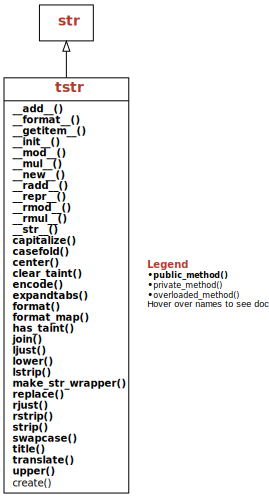

In [242]:
from ClassDiagram import display_class_hierarchy
display_class_hierarchy(tstr)

### Tracking Character Origins

`ostr` objects extend `tstr` objects by not only tracking a taint, but also the originating _indexes_ from the input string, This allows you to exactly track where individual characters came from. Assume you have a long string, which at index 100 contains the password `"joshua1234"`. Then you can save this origin information using an `ostr` as follows:

In [243]:
secret = ostr("joshua1234", origin=100, taint='SECRET')

The `origin` attribute of an `ostr` provides access to a list of indexes:

In [244]:
secret.origin

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

In [245]:
secret.taint

'SECRET'

`ostr` objects are compatible with Python strings, except that string operations return `ostr` objects (together with the saved origin an index information). An index of `-1` indicates that the corresponding character has no origin as supplied to the `ostr()` constructor:

In [246]:
secret_substr = (secret[0:4] + "-" + secret[6:])
secret_substr.taint

'SECRET'

In [247]:
secret_substr.origin

[100, 101, 102, 103, -1, 106, 107, 108, 109]

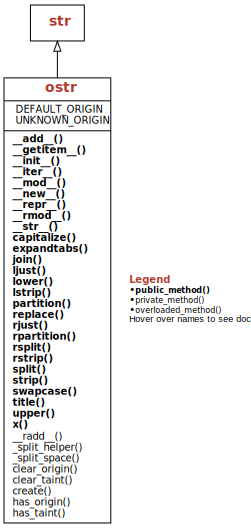

In [248]:
from ClassDiagram import display_class_hierarchy
display_class_hierarchy(ostr)

## Lessons Learned

* String-based and character-based taints allow to dynamically track the information flow from input to the internals of a system and back to the output.

* Checking taints allows to discover untrusted inputs and information leakage at runtime.

* Data conversions and implicit data flow may strip taint information; the resulting untainted strings should be treated as having the worst possible taint.

* Taints can be used in conjunction with fuzzing to provide a more robust indication of incorrect behavior than to simply rely on program crashes.

## Next Steps

An even better alternative to our taint-directed fuzzing is to make use of _symbolic_ techniques that take the semantics of the program under test into account.  The chapter on [flow fuzzing](FlowFuzzer.ipynb) introduces these symbolic techniques for the purpose of exploring information flows; the subsequent chapter on [symbolic fuzzing](SymbolicFuzzer.ipynb) then shows how to make full-fledged use of symbolic execution for covering code.  Similarly, [search based fuzzing](SearchBasedFuzzer.ipynb) can often provide a cheaper exploration strategy.

## Background

Taint analysis on Python using a library approach as we implemented in this chapter was discussed by Conti et al. \cite{Conti2010}.

## Exercises

### Exercise 1: Tainted Numbers

Introduce a class `tint` (for tainted integer) that, like `tstr`, has a taint attribute that gets passed on from `tint` to `tint`.

#### Part 1: Creation

Implement the `tint` class such that taints are set:

```python
x = tint(42, taint='SECRET')
assert x.taint == 'SECRET'
```

**Solution.** This is pretty straightforward, as we can apply the same scheme as for `tstr`:

In [249]:
class tint(int):
    def __new__(cls, value, *args, **kw):
        return int.__new__(cls, value)

    def __init__(self, value, taint=None, **kwargs):
        self.taint = taint

In [250]:
x = tint(42, taint='SECRET')
assert x.taint == 'SECRET'

#### Part 2: Arithmetic expressions

Ensure that taints get passed along arithmetic expressions; support addition, subtraction, multiplication, and division operators.
```python
y = x + 1
assert y.taint == 'SECRET'
```

**Solution.** As with `tstr`, we implement a `create()` method and a convenience function to quickly define all arithmetic operations:

In [251]:
class tint(tint):
    def create(self, n):
        # print("New tint from", n)
        return tint(n, taint=self.taint)

The `make_int_wrapper()` function creates a wrapper around an existing `int` method which attaches the taint to the result of the method:

In [252]:
def make_int_wrapper(fun):
    def proxy(self, *args, **kwargs):
        res = fun(self, *args, **kwargs)
        # print(fun, args, kwargs, "=", repr(res))
        return self.create(res)
    return proxy

We do this for all arithmetic operators:

In [253]:
for name in ['__add__', '__radd__', '__mul__', '__rmul__', '__sub__',
             '__floordiv__', '__truediv__']:
    fun = getattr(int, name)
    setattr(tint, name, make_int_wrapper(fun))

In [254]:
x = tint(42, taint='SECRET')
y = x + 1
y.taint  # type: ignore

'SECRET'

#### Part 3: Passing taints from integers to strings

Converting a tainted integer into a string (using `repr()`) should yield a tainted string:
```python
x_s = repr(x)
assert x_s.taint == 'SECRET'
```

**Solution.** We define the string conversion functions such that they return a tainted string (`tstr`):

In [255]:
class tint(tint):
    def __repr__(self) -> tstr:
        s = int.__repr__(self)
        return tstr(s, taint=self.taint)

In [256]:
class tint(tint):
    def __str__(self) -> tstr:
        return tstr(int.__str__(self), taint=self.taint)

In [257]:
x = tint(42, taint='SECRET')
x_s = repr(x)

In [258]:
assert isinstance(x_s, tstr)
assert x_s.taint == 'SECRET'

#### Part 4: Passing taints from strings to integers

Converting a tainted object (with a `taint` attribute) to an integer should pass that taint:

```python
password = tstr('1234', taint='NOT_EXACTLY_SECRET')
x = tint(password)
assert x == 1234
assert x.taint == 'NOT_EXACTLY_SECRET'
```

**Solution.** This can be done by having the `__init__()` constructor check for a `taint` attibute:

In [259]:
class tint(tint):
    def __init__(self, value, taint=None, **kwargs):
        if taint is not None:
            self.taint = taint
        else:
            self.taint = getattr(value, 'taint', None)

In [260]:
password = tstr('1234', taint='NOT_EXACTLY_SECRET')
x = tint(password)

In [261]:
assert x == 1234

In [262]:
assert x.taint == 'NOT_EXACTLY_SECRET'

### Exercise 2: Information Flow Testing

Generate tests that ensure a _maximum_ of information flow, propagating specific taints as much as possible.  Implement an appropriate fitness function for [search-based testing](SearchBasedFuzzer.ipynb) and let the search-based fuzzer search for solutions.

**Solution.** This will become a section on its own; as of now, it is an exercise for the reader.